In [1]:
#!Rscript generate_data.R

In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.model_selection import train_test_split

class PhiThreshDataset(Dataset):
    def __init__(self, data_dir):
        self.phi_dir = os.path.join(data_dir, 'Phi_mat')
        self.v_thresh_dir = os.path.join(data_dir, 'v_thresh')
        
        self.phi_files = [f for f in os.listdir(self.phi_dir) if f.startswith('Phi_mat_') and f.endswith('.txt')]
        self.v_thresh_files = [f for f in os.listdir(self.v_thresh_dir) if f.startswith('v_thresh_') and f.endswith('.txt')]

    def __len__(self):
        return len(self.phi_files)

    def __getitem__(self, idx):
        phi_file = os.path.join(self.phi_dir, self.phi_files[idx])
        phi = np.loadtxt(phi_file)
        
        v_thresh_file = os.path.join(self.v_thresh_dir, self.v_thresh_files[idx])
        v_thresh = np.loadtxt(v_thresh_file)

        return torch.tensor(phi, dtype=torch.float32), torch.tensor(v_thresh, dtype=torch.float32)

In [2]:
def get_data_loaders(data_dir, batch_size=32, test_size=0.2):
    dataset = PhiThreshDataset(data_dir)
    train_indices, test_indices = train_test_split(list(range(len(dataset))), test_size=test_size, random_state=42)
    
    train_set = torch.utils.data.Subset(dataset, train_indices)
    test_set = torch.utils.data.Subset(dataset, test_indices)
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [3]:
class PhiNet(nn.Module):
    def __init__(self, input_size):
        super(PhiNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, 1)
        
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = (torch.sigmoid(self.fc3(x)) + 1)*0.5 # Busquem el rang (0.5, 1)
        return x

In [8]:
def evaluate_model(model, train_loader, test_loader, criterion, verbose=True):
    model.eval()
    total_loss = 0.0
    losses_over_train = []
    with torch.no_grad():
        for inputs, targets in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            total_loss += loss.item()
            losses_over_train.append(loss.item())
    if verbose:
        print(f'Train Loss: {total_loss / len(train_loader):.4f}')
    
    total_loss = 0.0
    losses_over_test = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            total_loss += loss.item()
            losses_over_test.append(loss.item())
    if verbose:
        print(f'Test Loss: {total_loss / len(test_loader):.4f}')
    
    return losses_over_train, losses_over_test

def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", position=0, leave=True)
        for i, (inputs, targets) in progress_bar:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Running Loss: {running_loss / len(train_loader):.4f}')
        _, _ = evaluate_model(model, train_loader, test_loader, criterion)

In [9]:
data_dir = 'data'
input_size = len(np.loadtxt(os.path.join(data_dir, 'Phi_mat/Phi_mat_1.txt')))

hparams = {"batch_size": 16,
           "learning_rate": 0.01,
           "num_epochs": 10}

train_loader, test_loader = get_data_loaders(data_dir, batch_size=hparams["batch_size"])

model = PhiNet(input_size=input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=hparams["learning_rate"])

train_model(model, train_loader, criterion, optimizer, num_epochs=hparams["num_epochs"])

losses_over_train, losses_over_test = evaluate_model(model, train_loader, test_loader, criterion, verbose=False)

Epoch 1/10: 100%|██████████| 5/5 [00:00<00:00, 226.25it/s]


Epoch [1/10], Running Loss: 0.0390
Train Loss: 0.0258
Test Loss: 0.0203


Epoch 2/10: 100%|██████████| 5/5 [00:00<00:00, 246.34it/s]


Epoch [2/10], Running Loss: 0.0259
Train Loss: 0.0219
Test Loss: 0.0108


Epoch 3/10: 100%|██████████| 5/5 [00:00<00:00, 248.92it/s]


Epoch [3/10], Running Loss: 0.0186
Train Loss: 0.0137
Test Loss: 0.0216


Epoch 4/10: 100%|██████████| 5/5 [00:00<00:00, 250.80it/s]


Epoch [4/10], Running Loss: 0.0127
Train Loss: 0.0100
Test Loss: 0.0326


Epoch 5/10: 100%|██████████| 5/5 [00:00<00:00, 245.38it/s]


Epoch [5/10], Running Loss: 0.0095
Train Loss: 0.0076
Test Loss: 0.0342


Epoch 6/10: 100%|██████████| 5/5 [00:00<00:00, 247.84it/s]


Epoch [6/10], Running Loss: 0.0068
Train Loss: 0.0057
Test Loss: 0.0329


Epoch 7/10: 100%|██████████| 5/5 [00:00<00:00, 214.60it/s]


Epoch [7/10], Running Loss: 0.0047
Train Loss: 0.0041
Test Loss: 0.0389


Epoch 8/10: 100%|██████████| 5/5 [00:00<00:00, 247.55it/s]


Epoch [8/10], Running Loss: 0.0039
Train Loss: 0.0035
Test Loss: 0.0360


Epoch 9/10: 100%|██████████| 5/5 [00:00<00:00, 215.23it/s]


Epoch [9/10], Running Loss: 0.0042
Train Loss: 0.0032
Test Loss: 0.0382


Epoch 10/10: 100%|██████████| 5/5 [00:00<00:00, 214.18it/s]


Epoch [10/10], Running Loss: 0.0036
Train Loss: 0.0032
Test Loss: 0.0407


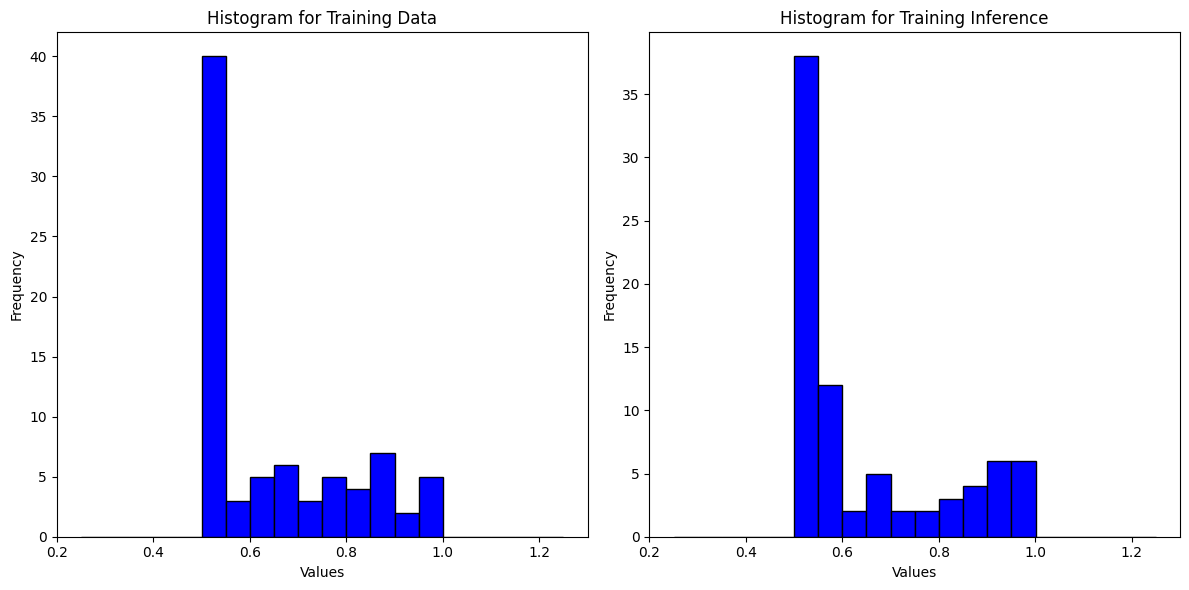

In [10]:
model.eval()

with torch.no_grad():
    total_train_loader = []
    for inputs, targets in train_loader:
        total_train_loader += targets.numpy().squeeze().tolist()
    
    total_train = []
    for inputs, targets in train_loader:
        total_train += model(inputs).numpy().squeeze().tolist()

bin_edges = [0.25, 0.3, 0.35, 0.4 , 0.45 , 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.001, 1.05, 1.1, 1.15, 1.2, 1.25]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

N, bins, patches = ax1.hist(total_train_loader, bins=bin_edges, edgecolor='black')
for i in range(0, 4+1):
    patches[i].set_facecolor('r')
for i in range(5,15):    
    patches[i].set_facecolor('b')
for i in range(15, len(patches)):
    patches[i].set_facecolor('r')
ax1.set_title('Histogram for Training Data')
ax1.set_xlabel('Values')
ax1.set_ylabel('Frequency')

N, bins, patches = ax2.hist(total_train, bins=bin_edges, edgecolor='black')
for i in range(0, 4+1):
    patches[i].set_facecolor('r')
for i in range(5,15):    
    patches[i].set_facecolor('b')
for i in range(15, len(patches)):
    patches[i].set_facecolor('r')
ax2.set_title('Histogram for Training Inference')
ax2.set_xlabel('Values')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

(array([1., 2., 0., 2.]),
 array([0.03123914, 0.04205573, 0.05287232, 0.06368891, 0.07450549]),
 <BarContainer object of 4 artists>)

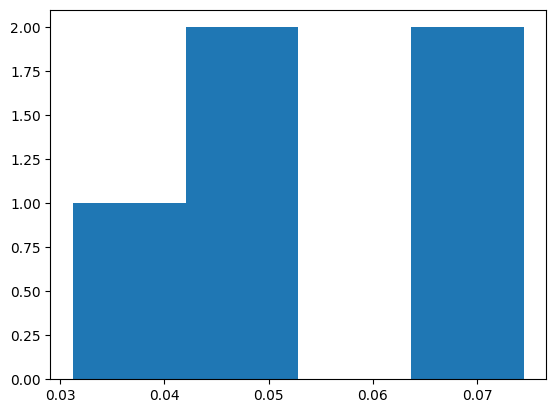

In [11]:
plt.hist(np.sqrt(losses_over_train), bins='auto')

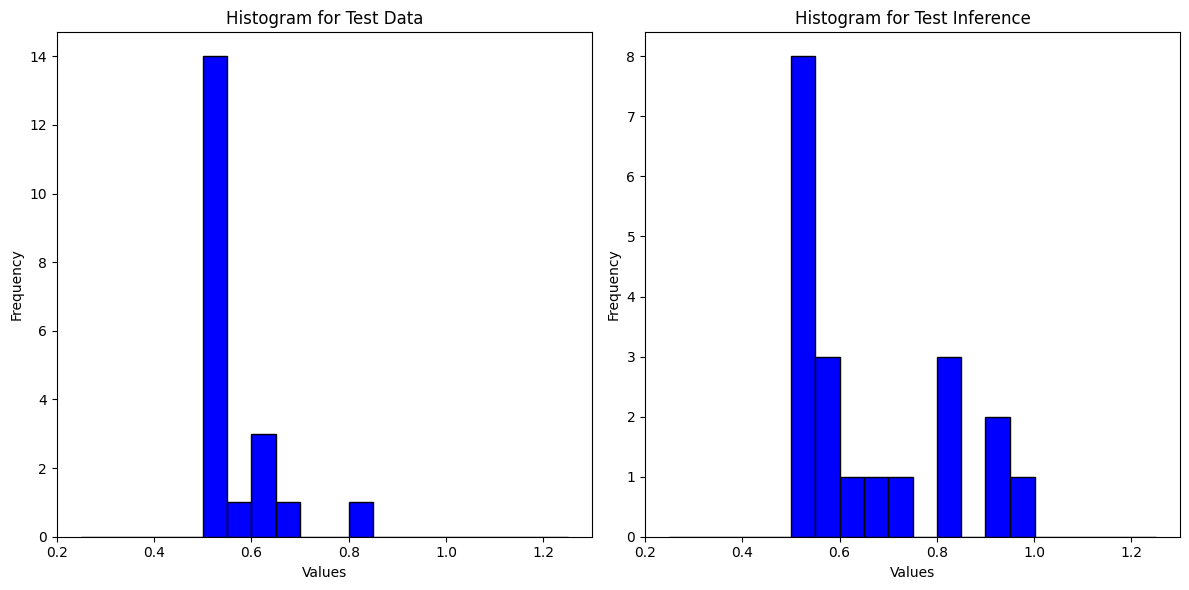

In [12]:
model.eval()

with torch.no_grad():
    total_test_loader = []
    for inputs, targets in test_loader:
        total_test_loader += targets.numpy().squeeze().tolist()
    
    total_test = []
    for inputs, targets in test_loader:
        total_test += model(inputs).numpy().squeeze().tolist()

bin_edges = [0.25, 0.3, 0.35, 0.4 , 0.45 , 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.001, 1.05, 1.1, 1.15, 1.2, 1.25]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

N, bins, patches = ax1.hist(total_test_loader, bins=bin_edges, edgecolor='black')
for i in range(0, 4+1):
    patches[i].set_facecolor('r')
for i in range(5,15):    
    patches[i].set_facecolor('b')
for i in range(15, len(patches)):
    patches[i].set_facecolor('r')
ax1.set_title('Histogram for Test Data')
ax1.set_xlabel('Values')
ax1.set_ylabel('Frequency')

N, bins, patches = ax2.hist(total_test, bins=bin_edges, edgecolor='black')
for i in range(0, 4+1):
    patches[i].set_facecolor('r')
for i in range(5,15):    
    patches[i].set_facecolor('b')
for i in range(15, len(patches)):
    patches[i].set_facecolor('r')
ax2.set_title('Histogram for Test Inference')
ax2.set_xlabel('Values')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

(array([1., 1.]),
 array([0.17033999, 0.19971543, 0.22909087]),
 <BarContainer object of 2 artists>)

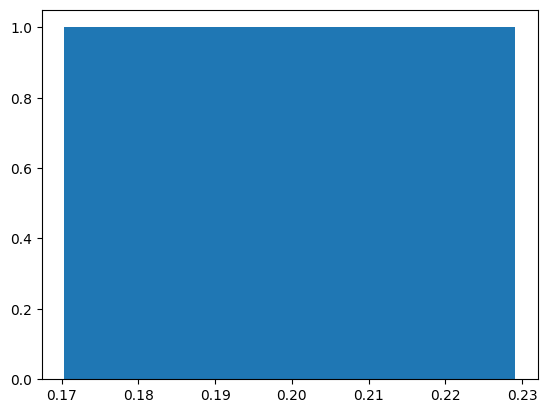

In [13]:
plt.hist(np.sqrt(losses_over_test), bins='auto')